In [15]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import numpy as np
from torchinfo import summary

In [16]:
### Ici, on va jouer sur le nombre de couches et les fonctions d'activations
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # Aplatit les entrées si ce n'est pas le cas
      nn.Linear(input_features, 512),
      nn.Sigmoid(), # nn.ReLU(),
      nn.Linear(512,128),
      nn.Sigmoid(), # nn.ReLU(),
      nn.Linear(128, 10)   # 10 car le nombre de classes = 10
    )

  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
    '''Forward pass'''
    return self.layers(x)


# class MLP(nn.Module):
#   '''
#     Multilayer Perceptron.
#   '''
#   def __init__(self,input_features=128):
#     super().__init__()
#     self.layers = nn.Sequential(
#       nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
#       nn.Linear(input_features, 512),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(512,256),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(256,128),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(128, 10)
#     )

# class MLP(nn.Module):
#   '''
#     Multilayer Perceptron.
#   '''
#   def __init__(self,input_features=128):
#     super().__init__()
#     self.layers = nn.Sequential(
#       nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
#       nn.Linear(input_features, 1024),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(1024,512),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(512,256),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(256,128),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(128, 10)
#     )


In [35]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Début de la boucle d'entraînement
    size = len(dataloader.dataset)  # Taille totale du jeu de données
    nb_batches = len(dataloader)     # Nombre total de lots dans le jeu de données
    epoch_loss = 0                   # Initialisation de la perte totale pour l'époque

    for batch, (X, y) in enumerate(dataloader):
        # X : données d'entrée, y : étiquettes correspondantes

        # Calcul de la prédiction du modèle et de la perte
        pred = model(X.float())  # Utilisation du modèle pour prédire les sorties
        loss = loss_fn(pred, y)  # Calcul de la perte entre les prédictions et les étiquettes réelles
        epoch_loss += loss.item()  # Ajout de la perte de ce lot à la perte totale de l'époque

        # Rétropropagation (Backpropagation)
        optimizer.zero_grad()  # Réinitialisation des gradients accumulés dans les paramètres du modèle
        loss.backward()       # Calcul des gradients par rétropropagation
        optimizer.step()       # Mise à jour des paramètres du modèle en fonction des gradients

    # Calcul de la perte moyenne pour l'époque et affichage
    average_loss = epoch_loss / nb_batches
    #print(f"\nPerte d'entraînement :", average_loss)

    # Retourne la perte moyenne pour l'époque
    return average_loss

def valid_loop(dataloader, model, loss_fn):
    # Début de la boucle de validation
    size = len(list(dataloader.dataset))  # Taille totale du jeu de données de validation
    nb_batches = len(dataloader)           # Nombre total de lots dans le jeu de données
    valid_loss = 0                         # Initialisation de la perte de validation

    with torch.no_grad():
        # Désactive le calcul des gradients pendant la validation
        for X, y in dataloader:
            # X : données d'entrée, y : étiquettes correspondantes

            # Calcul de la prédiction du modèle et de la perte
            pred = model(X.float())  # Utilisation du modèle pour prédire les sorties
            valid_loss += loss_fn(pred, y).item()  # Ajout de la perte de ce lot à la perte totale de validation

    # Calcul de la perte moyenne de validation et affichage
    valid_loss /= nb_batches
    #print("Perte de validation :", valid_loss)

    # Retourne la perte moyenne de validation
    return valid_loss

def perf_loop(dataloader, model):
    # Début de la boucle de performance
    Total = len(list(dataloader.dataset))  # Nombre total d'exemples dans le jeu de données de test
    nb_batches = len(dataloader)            # Nombre total de lots dans le jeu de données
    Positifs = 0                            # Initialisation du compteur de prédictions correctes

    with torch.no_grad():
        # Désactive le calcul des gradients pendant la performance
        for X, y in dataloader:
            # X : données d'entrée, y : étiquettes correspondantes

            # Calcul de la prédiction du modèle
            pred = model(X.float())  # Utilisation du modèle pour prédire les sorties

            # Calcul des probabilités de classe avec Softmax
            prob_pred = nn.Softmax(dim=1)(pred)

            # Prédiction de la classe avec la probabilité maximale
            y_pred = torch.argmax(prob_pred, dim=1)

            # Comparaison des prédictions avec les étiquettes réelles
            similaires = np.array(y_pred == y)
            Positifs += np.sum(similaires)

    # Retourne le nombre total de prédictions correctes, le nombre total d'exemples, et la dernière prédiction
    return Positifs, Total, y_pred

def affichage(dataloader, message):
  fig1, axs1 = plt.subplots(1,6,figsize=(6,1))
  image_batch, label_batch = next(iter(dataloader))
  for i in range(6):
    image = image_batch[i].squeeze().numpy() # squeeze les dimensions de longueur 1 : ici la dimension du canal de l'image
    message += str(label_batch[i].numpy())+" "
    plt.subplot(1,6,i+1)
    plt.imshow(image, cmap="gray")
  print(message)
  plt.show()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
#Set fixed random number seed
torch.manual_seed(42)

# Prepare MNIST dataset
dataset = MNIST(os.getcwd(), train = True, download=True, transform=transforms.ToTensor())
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/souna/Bureau/Master/master1/S2/DeepLearning/TP2
    Split: Train
    StandardTransform
Transform: ToTensor()

Train :4 7 5 4 3 1 


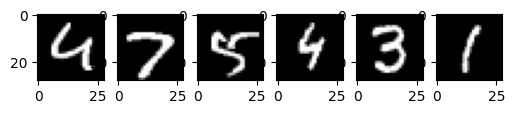

Valid :8 4 3 9 8 3 


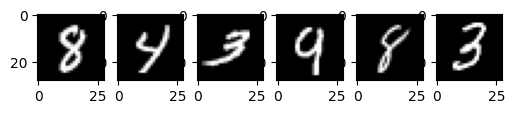

In [33]:
N = len(dataset)
N_train = int(N * 0.9)
N_valid = N - N_train
BATCH_SIZE = 60 # 128   
EPOCHS = 20 # 60
LEARNING_RATE = 1e-2 # 1e-3
OPTIM = "SGD" # "ADAM"
Model_name = "Mon_meilleur_MLP"

############### POUR LES FEATURES PIXELS #############
# il faut construire la valid et le train
train_dataset, valid_dataset = random_split(dataset, [N_train, N_valid])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
affichage(trainloader,"Train :")
affichage(validloader,"Valid :")

In [31]:
dim = 28 * 28
summary(model=MLP(input_features = dim),
        input_size=(BATCH_SIZE, 1, 28, 28), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
MLP (MLP)                                [60, 1, 28, 28]      [60, 10]             --                   True
├─Sequential (layers)                    [60, 1, 28, 28]      [60, 10]             --                   True
│    └─Flatten (0)                       [60, 1, 28, 28]      [60, 784]            --                   --
│    └─Linear (1)                        [60, 784]            [60, 512]            401,920              True
│    └─ReLU (2)                          [60, 512]            [60, 512]            --                   --
│    └─Linear (3)                        [60, 512]            [60, 128]            65,664               True
│    └─ReLU (4)                          [60, 128]            [60, 128]            --                   --
│    └─Linear (5)                        [60, 128]            [60, 10]             1,290                True
Total params: 468,87

 10%|█         | 2/20 [00:05<00:46,  2.56s/it]

best validation loss : 0.43556621015071867


 15%|█▌        | 3/20 [00:07<00:43,  2.53s/it]

best validation loss : 0.36437417708337305


 20%|██        | 4/20 [00:10<00:39,  2.48s/it]

best validation loss : 0.33396231681108474


 25%|██▌       | 5/20 [00:12<00:36,  2.44s/it]

best validation loss : 0.306718023121357


 30%|███       | 6/20 [00:14<00:33,  2.41s/it]

best validation loss : 0.29014464177191257


 35%|███▌      | 7/20 [00:17<00:31,  2.40s/it]

best validation loss : 0.27350868217647073


 40%|████      | 8/20 [00:19<00:28,  2.38s/it]

best validation loss : 0.2581691037118435


 45%|████▌     | 9/20 [00:21<00:26,  2.39s/it]

best validation loss : 0.24845077112317085


 50%|█████     | 10/20 [00:24<00:23,  2.38s/it]

best validation loss : 0.23565749634057284


 55%|█████▌    | 11/20 [00:26<00:21,  2.37s/it]

best validation loss : 0.22254989743232728


 60%|██████    | 12/20 [00:28<00:18,  2.36s/it]

best validation loss : 0.20905753523111342


 65%|██████▌   | 13/20 [00:31<00:16,  2.37s/it]

best validation loss : 0.20030989654362202


 70%|███████   | 14/20 [00:33<00:14,  2.43s/it]

best validation loss : 0.1903000921010971


 75%|███████▌  | 15/20 [00:36<00:12,  2.40s/it]

best validation loss : 0.18215329807251693


 80%|████████  | 16/20 [00:38<00:09,  2.39s/it]

best validation loss : 0.17222829338163137


 85%|████████▌ | 17/20 [00:40<00:07,  2.38s/it]

best validation loss : 0.16562679380178452


 90%|█████████ | 18/20 [00:43<00:04,  2.39s/it]

best validation loss : 0.16032049808651208


 95%|█████████▌| 19/20 [00:45<00:02,  2.38s/it]

best validation loss : 0.1522789904847741


100%|██████████| 20/20 [00:48<00:00,  2.40s/it]

best validation loss : 0.14660940706729889
Apprentisage terminé.



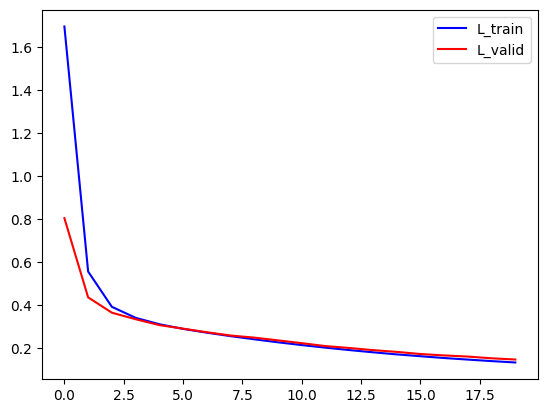

In [34]:
#################  Instanciation du MLP #################
dim = 28 * 28  # dimension des images MNIST
my_MLP = MLP(input_features = dim)
my_loss = nn.CrossEntropyLoss()
if OPTIM == "SGD":
    my_optimizer = torch.optim.SGD(my_MLP.parameters(), lr=LEARNING_RATE)
elif OPTIM == "ADAM":
    my_optimizer = torch.optim.Adam(my_MLP.parameters(), lr=LEARNING_RATE)
else:
    print("Optimiseur inconnu !!!!")

############      BOUCLES D'APPRENTISSAGE     ###########
train_loss = []
valid_loss = []
for t in tqdm(range(EPOCHS)):
    train_loss.append(train_loop(trainloader, my_MLP, my_loss, my_optimizer))
    # on test à chaque itération
    valid_loss.append(valid_loop(validloader, my_MLP, my_loss))
    # mettre ici le Early Stopping
    if t == 0:
        best_valid_loss = valid_loss[-1]
    else:
        if valid_loss[-1] < best_valid_loss:
            best_valid_loss = valid_loss[-1]
            print(f"best validation loss : {best_valid_loss}")
            # on mémorise ce modèle
            best_iter = t
            torch.save(my_MLP.state_dict(), Model_name)

print('Apprentisage terminé.\n')

# visu des loss train et test
plt.figure()
plt.plot(train_loss,"b",label="L_train")
plt.plot(valid_loss,"r",label="L_valid")
plt.legend()

Test :7 2 1 0 4 1 


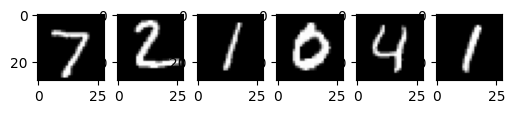

Taux de reco en Test: 1135 / 10000 = 11.35 % de réussite
Meilleure époque : 20
Nombre de paramètres libres: 468874


/tmp/ipykernel_7525/1268584892.py:70: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  similaires = np.array(y_pred == y)


In [22]:
############## on teste maintenaant les performances ################
test_dataset = MNIST(os.getcwd(), train = False, download=True, transform=transforms.ToTensor())
N_test = len(test_dataset)

##############
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=N_test, shuffle=False, num_workers=1)
affichage(testloader,"Test :")

my_best_MLP = MLP(input_features = dim)
my_best_MLP.load_state_dict(torch.load(Model_name))
Positifs, Total, y_pred = perf_loop(testloader, my_best_MLP)
print("Taux de reco en Test:",Positifs,"/", Total, "=", (Positifs/Total)*100, "% de réussite")
print("Meilleure époque :",best_iter+1)

nb_train_param = count_parameters(my_best_MLP)
print("Nombre de paramètres libres:",nb_train_param)

In [23]:
#---------------------------------------------------------------------------------

100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


Apprentisage terminé.



100%|██████████| 20/20 [01:01<00:00,  3.09s/it]

Apprentisage terminé.



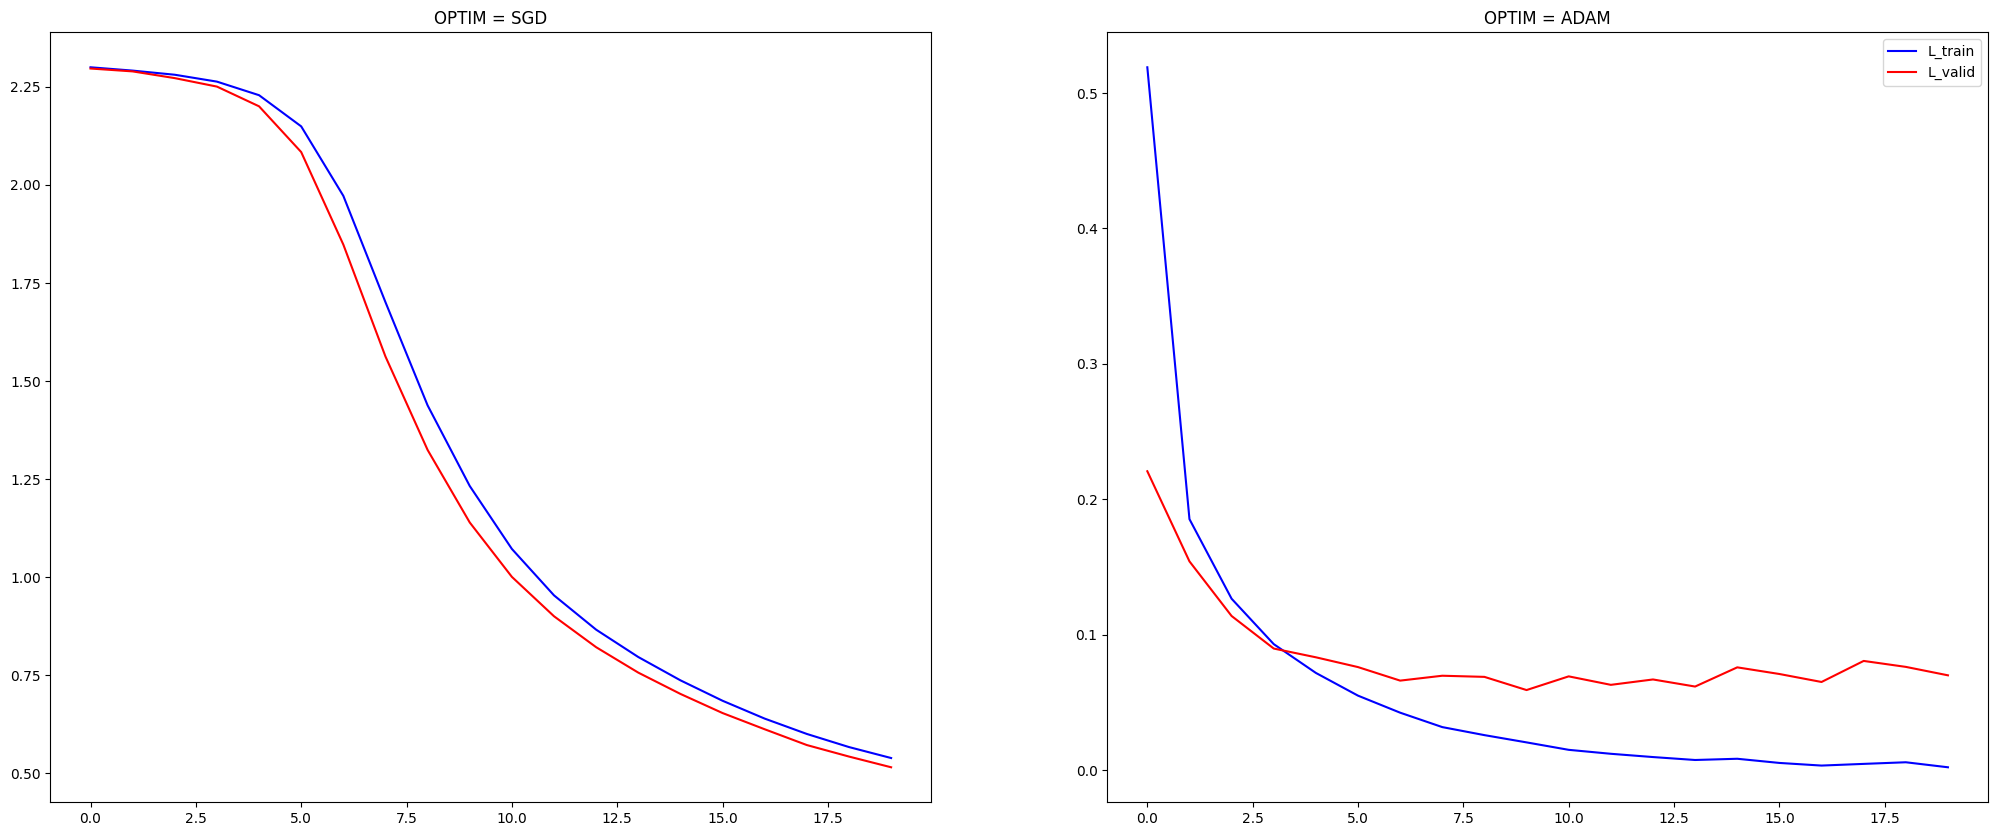

In [24]:
paramet=[["SGD",1e-2],["ADAM",1e-3]]
plt.subplots(1,2,figsize =(25, 10))
i=1
for val in paramet:
        N = len(dataset)
        N_train = int(N * 0.9)
        N_valid = N - N_train
        BATCH_SIZE = 64 # 128   
        EPOCHS = 20 # 60
        LEARNING_RATE = val[1] # 1e-3
        OPTIM = val[0] # "ADAM"
        Model_name = "Mon_meilleur_MLP"

        ############### POUR LES FEATURES PIXELS #############
        # il faut construire la valid et le train
        train_dataset, valid_dataset = random_split(dataset, [N_train, N_valid])
        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
        #-----------------------
        dim = 28 * 28
        #---------------------------
        #################  Instanciation du MLP #################
        dim = 28 * 28  # dimension des images MNIST
        my_MLP = MLP(input_features = dim)
        my_loss = nn.CrossEntropyLoss()
        if OPTIM == "SGD":
          my_optimizer = torch.optim.SGD(my_MLP.parameters(), lr=LEARNING_RATE)
        elif OPTIM == "ADAM":
          my_optimizer = torch.optim.Adam(my_MLP.parameters(), lr=LEARNING_RATE)
        else:
          print("Optimiseur inconnu !!!!")

        ############      BOUCLES D'APPRENTISSAGE     ###########
        train_loss = []
        valid_loss = []
        for t in tqdm(range(EPOCHS)):
           train_loss.append(train_loop(trainloader, my_MLP, my_loss, my_optimizer))
        # on test à chaque itération
           valid_loss.append(valid_loop(validloader, my_MLP, my_loss))
        # mettre ici le Early Stopping
           if t == 0:
                best_valid_loss = valid_loss[-1]
           else:
                if valid_loss[-1] < best_valid_loss:
                    best_valid_loss = valid_loss[-1]
                #print(f"best validation loss : {best_valid_loss}")
                # on mémorise ce modèle
                best_iter = t
                torch.save(my_MLP.state_dict(), Model_name)

        print('Apprentisage terminé.\n')

        # visu des loss train et test
        plt.subplot(1,2,i)
        plt.title(f'OPTIM = {val[0]}')
        plt.plot(train_loss,"b",label="L_train")
        plt.plot(valid_loss,"r",label="L_valid")

        i+=1
plt.legend()
plt.show()


In [25]:
### Ici, on va jouer sur le nombre de couches et les fonctions d'activations
class MLP1(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # Aplatit les entrées si ce n'est pas le cas
      nn.Linear(input_features, 512),
      nn.ReLU(),
      nn.Linear(512,128),
      nn.ReLU(),
      nn.Linear(128, 10)   # 10 car le nombre de classes = 10
    )

  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
    '''Forward pass'''
    return self.layers(x)
  
N = len(dataset)
N_train = int(N * 0.9)
N_valid = N - N_train
BATCH_SIZE = 64 # 128   
EPOCHS = 20 # 60
LEARNING_RATE = 1e-2 # 1e-3
OPTIM = "SGD" # "ADAM"
Model_name = "Mon_meilleur_MLP"

############### POUR LES FEATURES PIXELS #############
# il faut construire la valid et le train
train_dataset, valid_dataset = random_split(dataset, [N_train, N_valid])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [26]:
#################  Instanciation du MLP #################
dim = 28 * 28  # dimension des images MNIST
def myclasse(modele,focntion):
        my_MLP = modele(input_features = dim)
        my_loss = nn.CrossEntropyLoss()
        if OPTIM == "SGD":
            my_optimizer = torch.optim.SGD(my_MLP.parameters(), lr=LEARNING_RATE)
        elif OPTIM == "ADAM":
            my_optimizer = torch.optim.Adam(my_MLP.parameters(), lr=LEARNING_RATE)
        else:
            print("Optimiseur inconnu !!!!")

        ############      BOUCLES D'APPRENTISSAGE     ###########
        train_loss = []
        valid_loss = []
        for t in tqdm(range(EPOCHS)):
            train_loss.append(train_loop(trainloader, my_MLP, my_loss, my_optimizer))
            # on test à chaque itération
            valid_loss.append(valid_loop(validloader, my_MLP, my_loss))
            # mettre ici le Early Stopping
            if t == 0:
                best_valid_loss = valid_loss[-1]
            else:
                if valid_loss[-1] < best_valid_loss:
                    best_valid_loss = valid_loss[-1]
                    print(f"best validation loss : {best_valid_loss}")
                    # on mémorise ce modèle
                    best_iter = t
                    torch.save(my_MLP.state_dict(), Model_name)

        print('Apprentisage terminé.\n')

        # visu des loss train et test
        
        plt.title(f'Fonction d activation {focntion}')
        plt.plot(train_loss,"b",label="L_train")
        plt.plot(valid_loss,"r",label="L_valid")
        plt.legend()

 10%|█         | 2/20 [00:04<00:41,  2.33s/it]

best validation loss : 2.2838911046373083


 15%|█▌        | 3/20 [00:06<00:39,  2.33s/it]

best validation loss : 2.270897850077203


 20%|██        | 4/20 [00:09<00:37,  2.35s/it]

best validation loss : 2.2488641814982637


 25%|██▌       | 5/20 [00:11<00:34,  2.33s/it]

best validation loss : 2.2030771488839007


 30%|███       | 6/20 [00:13<00:32,  2.32s/it]

best validation loss : 2.095453921784746


 35%|███▌      | 7/20 [00:16<00:29,  2.30s/it]

best validation loss : 1.8655705375874296


 40%|████      | 8/20 [00:18<00:27,  2.31s/it]

best validation loss : 1.5512899680340544


 45%|████▌     | 9/20 [00:20<00:25,  2.28s/it]

best validation loss : 1.276763676328862


 50%|█████     | 10/20 [00:23<00:23,  2.32s/it]

best validation loss : 1.0750482653049713


 55%|█████▌    | 11/20 [00:25<00:20,  2.31s/it]

best validation loss : 0.938066247295826


 60%|██████    | 12/20 [00:27<00:18,  2.30s/it]

best validation loss : 0.8412948276134248


 65%|██████▌   | 13/20 [00:30<00:16,  2.29s/it]

best validation loss : 0.7692251655649631


 70%|███████   | 14/20 [00:32<00:13,  2.29s/it]

best validation loss : 0.712063952963403


 75%|███████▌  | 15/20 [00:34<00:11,  2.28s/it]

best validation loss : 0.6622383474035466


 80%|████████  | 16/20 [00:36<00:09,  2.28s/it]

best validation loss : 0.6215807979411268


 85%|████████▌ | 17/20 [00:39<00:06,  2.29s/it]

best validation loss : 0.5883288212279056


 90%|█████████ | 18/20 [00:41<00:04,  2.28s/it]

best validation loss : 0.5561701316148677


 95%|█████████▌| 19/20 [00:43<00:02,  2.27s/it]

best validation loss : 0.5319525859457381


100%|██████████| 20/20 [00:45<00:00,  2.30s/it]


best validation loss : 0.5115164153753443
Apprentisage terminé.



 10%|█         | 2/20 [00:04<00:40,  2.27s/it]

best validation loss : 0.4405685490433206


 15%|█▌        | 3/20 [00:06<00:39,  2.34s/it]

best validation loss : 0.36474663098441795


 20%|██        | 4/20 [00:09<00:36,  2.29s/it]

best validation loss : 0.33361121124409615


 25%|██▌       | 5/20 [00:11<00:34,  2.28s/it]

best validation loss : 0.31299214128484115


 30%|███       | 6/20 [00:13<00:31,  2.27s/it]

best validation loss : 0.2949693839442223


 35%|███▌      | 7/20 [00:15<00:29,  2.26s/it]

best validation loss : 0.2758551148816626


 40%|████      | 8/20 [00:18<00:27,  2.26s/it]

best validation loss : 0.26119830166088776


 45%|████▌     | 9/20 [00:20<00:24,  2.26s/it]

best validation loss : 0.2484378404122718


 50%|█████     | 10/20 [00:22<00:22,  2.27s/it]

best validation loss : 0.23690948298478381


 55%|█████▌    | 11/20 [00:24<00:20,  2.25s/it]

best validation loss : 0.2251008708584816


 60%|██████    | 12/20 [00:27<00:18,  2.25s/it]

best validation loss : 0.21737659841458848


 65%|██████▌   | 13/20 [00:29<00:15,  2.25s/it]

best validation loss : 0.20399336176032715


 70%|███████   | 14/20 [00:31<00:13,  2.25s/it]

best validation loss : 0.19582734665179508


 75%|███████▌  | 15/20 [00:33<00:11,  2.24s/it]

best validation loss : 0.18890562851695306


 80%|████████  | 16/20 [00:36<00:09,  2.29s/it]

best validation loss : 0.18040957167110544


 85%|████████▌ | 17/20 [00:38<00:06,  2.28s/it]

best validation loss : 0.17080321571135776


 90%|█████████ | 18/20 [00:40<00:04,  2.27s/it]

best validation loss : 0.16626020631891616


 95%|█████████▌| 19/20 [00:43<00:02,  2.26s/it]

best validation loss : 0.16024535085926664


100%|██████████| 20/20 [00:45<00:00,  2.26s/it]

best validation loss : 0.15451452365898072
Apprentisage terminé.



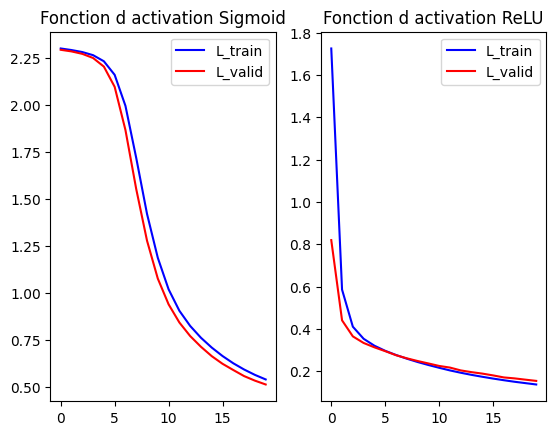

In [27]:
plt.subplots(1,2)
plt.subplot(1,2,1)
myclasse(MLP,'Sigmoid')
plt.subplot(1,2,2)
myclasse(MLP1,'ReLU')

In [28]:
### Ici, on va jouer sur le nombre de couches et les fonctions d'activations
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # Aplatit les entrées si ce n'est pas le cas
      nn.Linear(input_features, 512),
      nn.ReLU(),
      nn.Linear(512,128),
      nn.ReLU(),
      nn.Linear(128, 10)   # 10 car le nombre de classes = 10
    )

  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
    '''Forward pass'''
    return self.layers(x)
  
class MLP2(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # Aplatit les entrées si ce n'est pas le cas
      nn.Linear(input_features, 256),
      nn.ReLU(),
      nn.Linear(256, 10)   # 10 car le nombre de classes = 10
    )

  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
    '''Forward pass'''
    return self.layers(x)


class MLP4(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
      nn.Linear(input_features, 512),
      nn.ReLU(), #nn.Sigmoid(),
      nn.Linear(512,256),
      nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
      nn.Linear(256,128),
      nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
      nn.Linear(128, 10)
    )
  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
      '''Forward pass'''
      return self.layers(x)

# class MLP(nn.Module):
#   '''
#     Multilayer Perceptron.
#   '''
#   def __init__(self,input_features=128):
#     super().__init__()
#     self.layers = nn.Sequential(
#       nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
#       nn.Linear(input_features, 1024),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(1024,512),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(512,256),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(256,128),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(128, 10)
#     )


 10%|█         | 2/20 [00:06<00:59,  3.32s/it]

best validation loss : 0.08981692806837406


 15%|█▌        | 3/20 [00:09<00:55,  3.27s/it]

best validation loss : 0.08650776547716653


 20%|██        | 4/20 [00:12<00:51,  3.21s/it]

best validation loss : 0.06322624071184149


100%|██████████| 20/20 [01:02<00:00,  3.15s/it]


Apprentisage terminé.



 10%|█         | 2/20 [00:07<01:05,  3.62s/it]

best validation loss : 0.10043500974140268


 15%|█▌        | 3/20 [00:10<01:01,  3.61s/it]

best validation loss : 0.09310868603890722


 20%|██        | 4/20 [00:14<00:58,  3.63s/it]

best validation loss : 0.08679031006288418


 30%|███       | 6/20 [00:21<00:50,  3.60s/it]

best validation loss : 0.07800350550616636


100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Apprentisage terminé.



 10%|█         | 2/20 [00:04<00:40,  2.26s/it]

best validation loss : 0.1229342234499277


 15%|█▌        | 3/20 [00:06<00:38,  2.25s/it]

best validation loss : 0.1118809488463275


 20%|██        | 4/20 [00:09<00:36,  2.25s/it]

best validation loss : 0.0909704382907837


 25%|██▌       | 5/20 [00:11<00:34,  2.31s/it]

best validation loss : 0.08392007571664896


 35%|███▌      | 7/20 [00:15<00:29,  2.28s/it]

best validation loss : 0.07957492211952488


100%|██████████| 20/20 [00:45<00:00,  2.26s/it]


Apprentisage terminé.



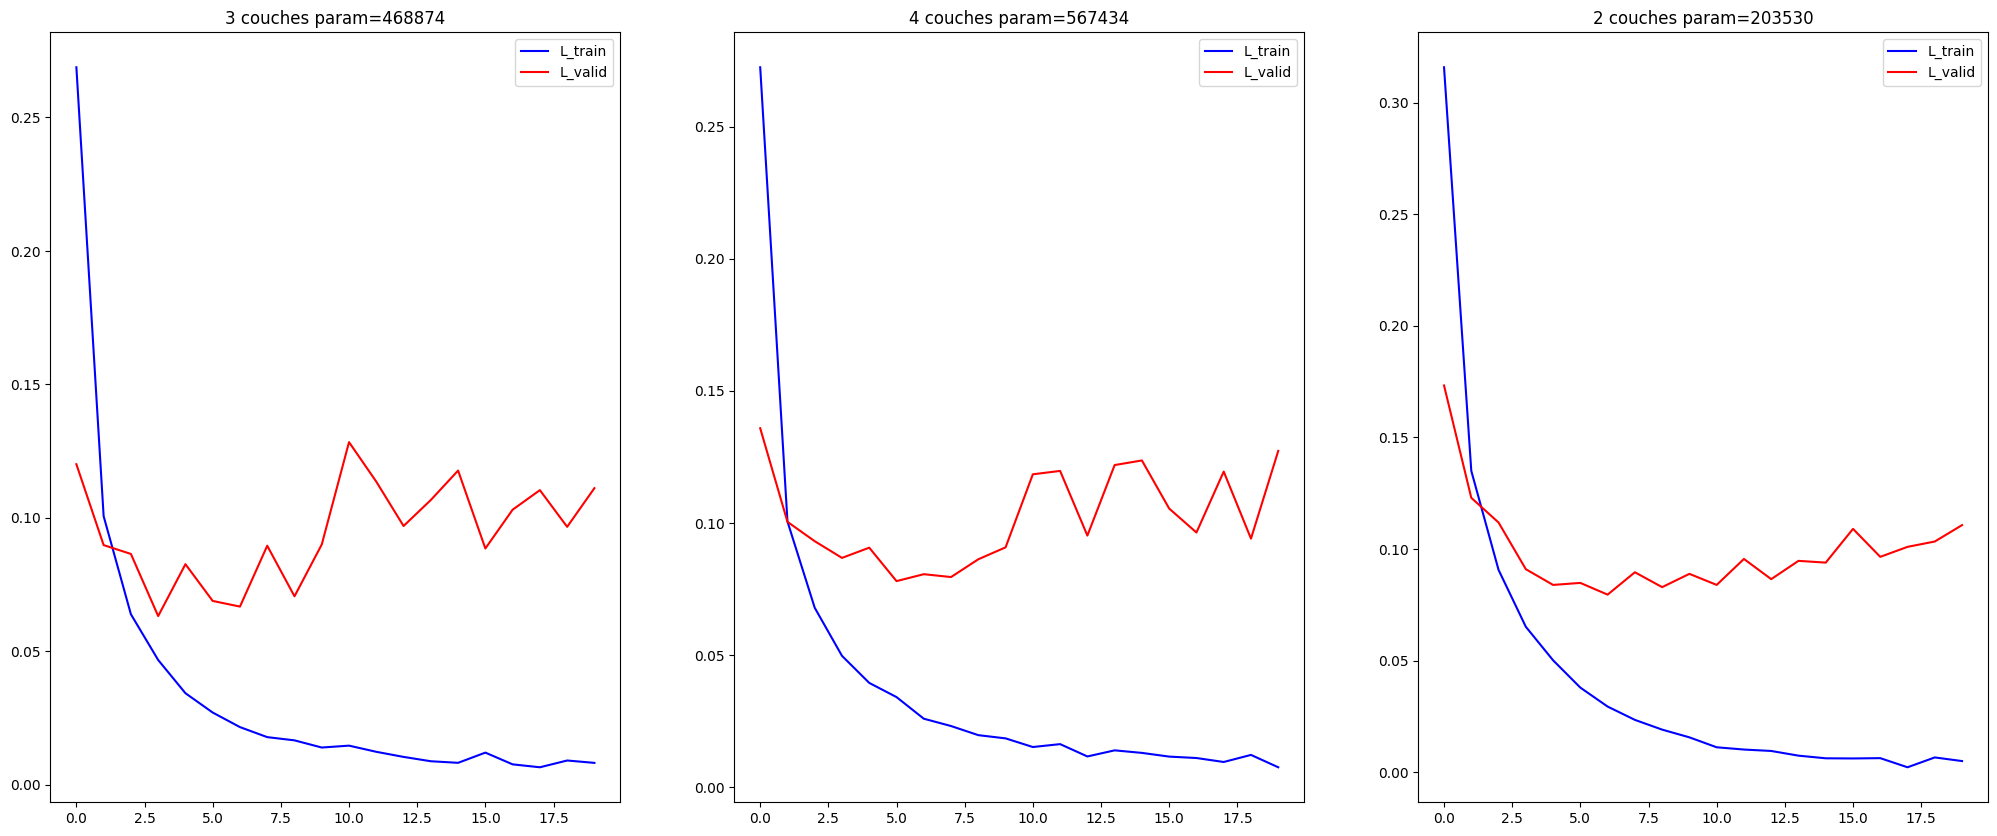

In [36]:
#################  Instanciation du MLP #################
N = len(dataset)
N_train = int(N * 0.9)
N_valid = N - N_train
BATCH_SIZE = 64 # 128   
EPOCHS = 20 # 60
LEARNING_RATE = 1e-3 # 1e-3
OPTIM = "ADAM" # "ADAM"
Model_name = "Mon_meilleur_MLP"
plt.subplots(1,3,figsize =(25, 10))
i=1
mod=[MLP,MLP4,MLP2]
nom=['3 couches','4 couches','2 couches']
for modd in mod:
    ############### POUR LES FEATURES PIXELS #############
    # il faut construire la valid et le train
    train_dataset, valid_dataset = random_split(dataset, [N_train, N_valid])
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
    dim = 28 * 28  # dimension des images MNIST
    my_MLP = modd(input_features = dim)
    my_loss = nn.CrossEntropyLoss()
    if OPTIM == "SGD":
        my_optimizer = torch.optim.SGD(my_MLP.parameters(), lr=LEARNING_RATE)
    elif OPTIM == "ADAM":
        my_optimizer = torch.optim.Adam(my_MLP.parameters(), lr=LEARNING_RATE)
    else:
        print("Optimiseur inconnu !!!!")

    ############      BOUCLES D'APPRENTISSAGE     ###########
    train_loss = []
    valid_loss = []
    for t in tqdm(range(EPOCHS)):
        train_loss.append(train_loop(trainloader, my_MLP, my_loss, my_optimizer))
        # on test à chaque itération
        valid_loss.append(valid_loop(validloader, my_MLP, my_loss))
        # mettre ici le Early Stopping
        if t == 0:
            best_valid_loss = valid_loss[-1]
        else:
            if valid_loss[-1] < best_valid_loss:
                best_valid_loss = valid_loss[-1]
                print(f"best validation loss : {best_valid_loss}")
                # on mémorise ce modèle
                best_iter = t
                torch.save(my_MLP.state_dict(), Model_name)

    print('Apprentisage terminé.\n')

    # visu des loss train et test
    plt.subplot(1,3,i)
    plt.title(f'{nom[i-1]} param={count_parameters(my_MLP)}')
    plt.plot(train_loss,"b",label="L_train")
    plt.plot(valid_loss,"r",label="L_valid")
    plt.legend()
    i+=1